In [22]:
%matplotlib inline
from typing import Any, cast

import d2l.d2l as d2l
import matplotlib.pyplot as plt
import numpy as np
import structlog
import torch
import torchvision
from IPython.core.interactiveshell import InteractiveShell
from torch.utils import data
from torchvision import transforms

logger = structlog.get_logger()

InteractiveShell.ast_node_interactivity = "all"  # type:ignore

In [2]:
d2l.use_svg_display()

In [3]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True
)
minist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True
)

2026-02-01 12:08:05 [info     ] sample data                   


(60000, 10000)

torchvision.datasets.mnist.FashionMNIST

2

2026-02-01 12:08:05 [info     ] feature                       


torch.Size([1, 28, 28])

torch.Tensor

2026-02-01 12:08:05 [info     ] label                         


9

int

2026-02-01 12:08:05 [info     ] plot sample data              


array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

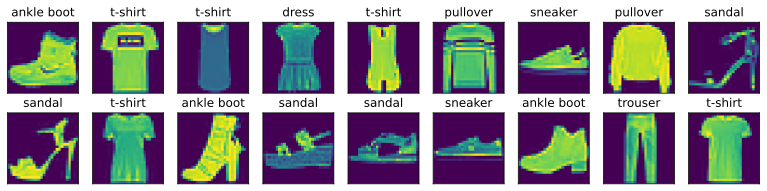

2026-02-01 12:08:06 [info     ] load mini batch data          
2026-02-01 12:08:13 [info     ] time spent                     time=7.32361912727356


In [16]:
logger.info("sample data")
len(mnist_train), len(minist_test)

type(mnist_train)

len(mnist_train[0])
logger.info("feature ")  # tensor
mnist_train[0][0].shape
type(mnist_train[0][0])

logger.info("label ")  # integer
mnist_train[0][1]
type(mnist_train[0][1])


def get_labels(labels):
    """return text labels"""
    text_labels = [
        "t-shirt",
        "trouser",
        "pullover",
        "dress",
        "coat",
        "sandal",
        "shirt",
        "sneaker",
        "bag",
        "ankle boot",
    ]
    return [text_labels[int(i)] for i in labels]


def show_images(imgs, n_rows, n_cols, titles=None, scale=1.5):
    figsize = (n_cols * scale, n_rows * scale)
    _, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = cast(np.ndarray, axes)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes.flatten(), imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


logger.info("plot sample data")
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_labels(y))
plt.show()

logger.info("load mini batch data")
batch_size = 256


def get_dataloader_workers():
    return 4


train_iter = data.DataLoader(
    mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()
)
timer = d2l.Timer()
for X, y in train_iter:  # noqa: B007
    continue

logger.info("time spent", time=timer.stop())


* put together

In [18]:
def load_data_fashion_mnist(
    batch_size: int,
    resize: tuple[int, int] | int | None = None,
) -> tuple[data.DataLoader, data.DataLoader]:
    """init data loader for dataset"""
    trans_list: list[Any] = [transforms.ToTensor()]
    if resize:
        trans_list.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans_list)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True
    )
    return (
        data.DataLoader(
            mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()
        ),
        data.DataLoader(
            mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_workers()
        ),
    )


In [20]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:  # noqa: B007
    print(X.shape, X.dtype, y.shape, y.dtype)
    break


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# implement softmax

In [41]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

n_input = 784
n_output = 10
W = torch.normal(0, 0.01, size=(n_input, n_output), requires_grad=True)
b = torch.zeros(n_output, requires_grad=True)

logger.info("example softmax op")
X = torch.tensor([[1.0, 2.0, 3.0], [4, 5, 6.0]])
X.sum(dim=0, keepdim=True)
X.sum(dim=1, keepdim=True)


logger.info("define softmax")


def softmax(x):
    exp_x = torch.exp(x)
    return exp_x / torch.sum(exp_x, dim=1, keepdim=True)


x = torch.normal(0, 1, (2, 5))
x_prob = softmax(x)
x_prob
x_prob.sum(1)

logger.info("implement reg")


def net(x):
    return softmax(torch.matmul(x.reshape(-1, W.shape[0]), W) + b)  # type:ignore


y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

y_hat.shape
len(y_hat)


def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y)), y])


cross_entropy(y_hat, y)


def get_n_correct(y_hat: torch.Tensor, y: torch.Tensor):
    """eval metric"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_pred = y_hat.argmax(dim=1)
    else:
        y_pred = torch.ones_like(y_hat)
    return float((y_pred.type(y.dtype) == y).sum())


get_n_correct(y_hat, y) / y.shape[0]


def eval_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()  # set to evaluation mode
    n_correct, n_total = 0, 0
    for X, y in data_iter:
        n_correct += get_n_correct(net(X), y)
        n_total += y.numel()
    return n_correct / n_total


eval_accuracy(net, test_iter)


2026-02-01 13:38:11 [info     ] example softmax op            


tensor([[5., 7., 9.]])

tensor([[ 6.],
        [15.]])

2026-02-01 13:38:11 [info     ] define softmax                


tensor([[0.2894, 0.1554, 0.1772, 0.2585, 0.1195],
        [0.2693, 0.0672, 0.0155, 0.3912, 0.2568]])

tensor([1.0000, 1.0000])

2026-02-01 13:38:11 [info     ] implement reg                 


tensor([0.1000, 0.5000])

torch.Size([2, 3])

2

tensor([2.3026, 0.6931])

0.5

0.0696

In [50]:
y_hat.size().numel()
y_hat.numel()
y.size()
y.size().numel()
y.numel()

6

6

torch.Size([2])

2

2

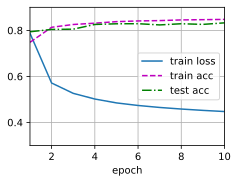

In [ ]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

n_input = 784
n_output = 10
W = torch.normal(0, 0.01, size=(n_input, n_output), requires_grad=True)
b = torch.zeros(n_output, requires_grad=True)

lr = 0.1


def softmax(x):
    exp_x = torch.exp(x)
    return exp_x / torch.sum(exp_x, dim=1, keepdim=True)


def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y)), y])


def get_n_correct(y_hat: torch.Tensor, y: torch.Tensor):
    """eval metric"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_pred = y_hat.argmax(dim=1)
    else:
        y_pred = torch.ones_like(y_hat)
    return float((y_pred.type(y.dtype) == y).sum())


def net(x):
    return softmax(torch.matmul(x.reshape(-1, W.shape[0]), W) + b)  # type:ignore


def eval_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()  # set to evaluation mode
    n_correct, n_total = 0, 0
    for X, y in data_iter:
        n_correct += get_n_correct(net(X), y)
        n_total += y.numel()
    return n_correct / n_total


def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        _loss = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            _loss.mean().backward()
            updater.step()
        else:
            _loss.sum().backward()
            updater(X.shape[0])
        metric.add(
            float(_loss.sum()),  # total loss (mean * n_sample)
            get_n_correct(y_hat, y),  # n_correct
            y.numel(),  # n total
        )
    return metric[0] / metric[2], metric[1] / metric[2]


def train_ch3(net, train_iter, test_iter, loss, n_epoch, updater):
    animator = d2l.Animator(
        xlabel="epoch",
        xlim=[1, n_epoch],
        ylim=[0.3, 0.9],
        legend=["train loss", "train acc", "test acc"],
    )
    train_metrics = None
    test_acc = None
    for epoch in range(n_epoch):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = eval_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    assert train_metrics is not None and test_acc is not None
    train_loss, train_acc = train_metrics
    # sanity check at the end of training.
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


def updater(batch_size):
    # pass W,b as global variable.
    return d2l.sgd([W, b], lr, batch_size)


def predict_ch3(net, test_iter: data.DataLoader, n: int = 6):
    """show predict"""
    X, y = next(iter(test_iter))
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1))
    titles = [true + "\n" + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])


n_epoch = 10

train_ch3(net, train_iter, test_iter, cross_entropy, n_epoch=n_epoch, updater=updater)


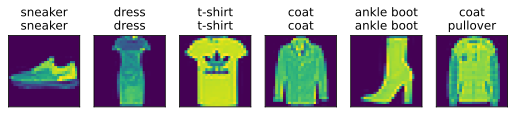

In [ ]:
predict_ch3(net, test_iter)

In [57]:
torch.exp(torch.tensor(50.0))

tensor(5.1847e+21)

# implement softmax using torch

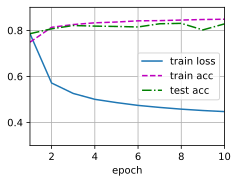

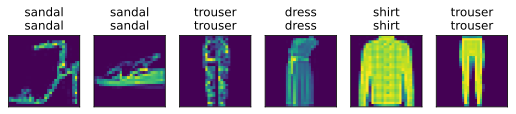

In [61]:
from torch import nn

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

n_input = 784
n_output = 10
W = torch.normal(0, 0.01, size=(n_input, n_output), requires_grad=True)
b = torch.zeros(n_output, requires_grad=True)

lr = 0.1

net = nn.Sequential(nn.Flatten(), nn.Linear(n_input, n_output))


def init_weight(m):
    """init weight for given layer"""
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weight)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_ch3(
    net,
    train_iter,
    test_iter,
    loss=loss,
    updater=trainer,
    n_epoch=n_epoch,
)

predict_ch3(net, test_iter)
